In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 25.4 MB/s eta 0:00:00


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6902
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6738 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6529 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6355 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6031  
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5778 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5569 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5025 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4443 
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4032  
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4060 
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3278 
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3026
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3703
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3147 
Epoch 16/100
5/5 ━

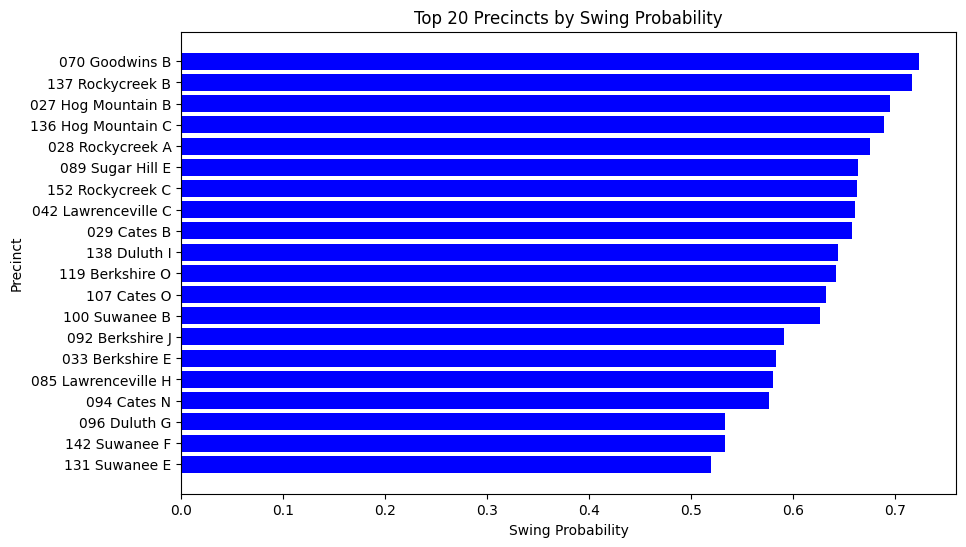

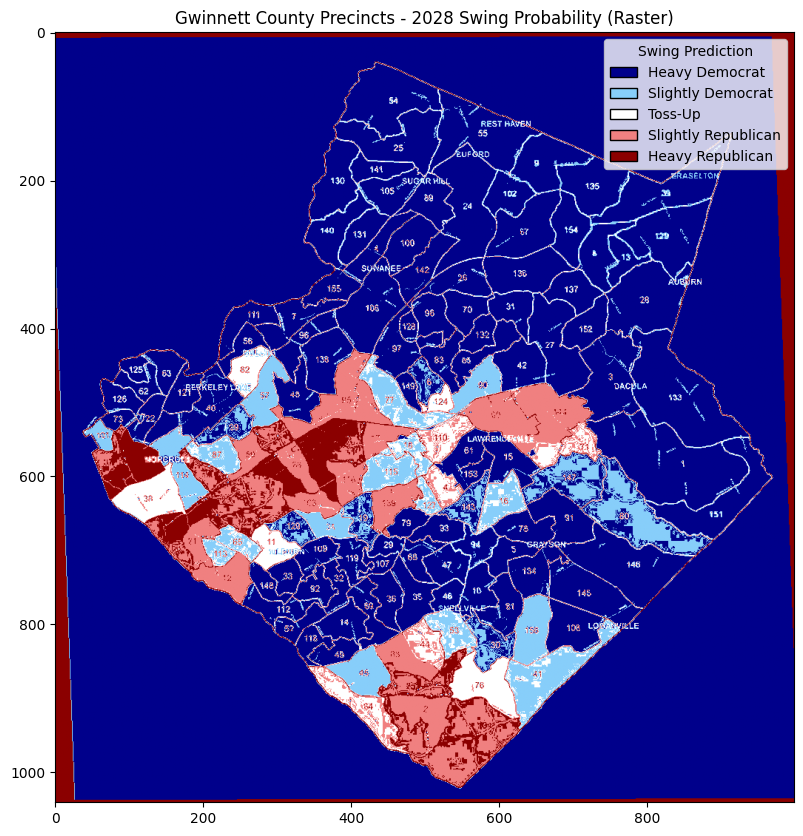

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import geopandas as gpd
from PIL import Image
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from matplotlib.colors import ListedColormap

def logistic(x):
    """Sigmoid function to model swing probability."""
    return 1 / (1 + np.exp(-x))

def clean_presidential_data_2024(file_path):
    df = pd.read_excel(file_path)
    df = df[df['Office Name'] == 'President of the US']
    df = df[['Precinct', 'Ballot Name', 'Party', 'Total']]
    df = df[~df['Ballot Name'].isin(['Total Votes', 'Ballots Cast'])]
    df['Total'] = pd.to_numeric(df['Total'], errors='coerce')
    return df.dropna()

def clean_presidential_data_2020(file_path):
    df = pd.read_excel(file_path)
    candidates = df.iloc[0, 1:].dropna().tolist()
    df = df.iloc[1:].reset_index(drop=True)
    column_mapping = ['Precinct', 'Registered Voters']
    for candidate in candidates:
        column_mapping.extend([
            f'{candidate}_ElectionDay', f'{candidate}_Advanced', f'{candidate}_Absentee', f'{candidate}_Provisional', f'{candidate}_Total'
        ])
    column_mapping.append("Total")
    df.columns = column_mapping
    candidate_totals = [col for col in df.columns if '_Total' in col]
    df = df[['Precinct'] + candidate_totals]
    df[candidate_totals] = df[candidate_totals].apply(pd.to_numeric, errors='coerce')
    df_melted = df.melt(id_vars=['Precinct'], var_name='Candidate', value_name='Total')
    df_melted['Ballot Name'] = df_melted['Candidate'].str.replace('_Total', '', regex=True)
    return df_melted[['Precinct', 'Ballot Name', 'Total']].dropna()

def calculate_swing_probabilities(df):
    swing_probs = []
    df['Total'] = pd.to_numeric(df['Total'], errors='coerce')
    df = df.dropna()
    for precinct, group in df.groupby('Precinct'):
        sorted_group = group.sort_values(by='Total', ascending=False)
        if len(sorted_group) < 2:
            continue
        top1, top2 = sorted_group.iloc[0]['Total'], sorted_group.iloc[1]['Total']
        total_votes = top1 + top2
        if total_votes == 0:
            continue
        margin = abs(top1 - top2) / total_votes
        swing_prob = 1 - logistic((margin - 0.05) * 20)
        swing_probs.append((precinct, swing_prob))
    return swing_probs

def train_model(train_data, labels):
    inputs = layers.Input(shape=(train_data.shape[1],))
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Reshape((1, 32))(x)
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    history = model.fit(train_data, labels, epochs=100, verbose=1)
    return model, history.history['loss']

def plot_top_swing_precincts(df_swing):
    top_precincts = df_swing.nlargest(20, 'Swing Probability')
    plt.figure(figsize=(10, 6))
    plt.barh(top_precincts['Precinct'], top_precincts['Swing Probability'], color='blue')
    plt.xlabel('Swing Probability')
    plt.ylabel('Precinct')
    plt.title('Top 20 Precincts by Swing Probability')
    plt.gca().invert_yaxis()
    plt.show()

def plot_gwinnett_raster(raster_path, swing_data):
    """Displays the GeoTIFF raster layer with swing probability visualization."""
    with rasterio.open(raster_path) as src:
        img = src.read(1)  # Read first band
        transform = src.transform

    # Normalize swing probabilities to a scale of 0-1 for color mapping
    swing_values = np.array([prob for _, prob in swing_data])
    min_val, max_val = swing_values.min(), swing_values.max()
    norm_probs = (swing_values - min_val) / (max_val - min_val)

    # Create a color map
    cmap = ListedColormap(["darkred", "lightcoral", "white", "lightskyblue", "darkblue"])
    thresholds = [0.0, 0.25, 0.49, 0.51, 0.75, 1.0]

    fig, ax = plt.subplots(figsize=(10, 10))
    img_masked = np.interp(img, (img.min(), img.max()), (0, 1))  # Scale image to match [0,1]
    ax.imshow(img_masked, cmap=cmap, vmin=0, vmax=1)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='darkblue', edgecolor='black', label='Heavy Democrat'),
        Patch(facecolor='lightskyblue', edgecolor='black', label='Slightly Democrat'),
        Patch(facecolor='white', edgecolor='black', label='Toss-Up'),
        Patch(facecolor='lightcoral', edgecolor='black', label='Slightly Republican'),
        Patch(facecolor='darkred', edgecolor='black', label='Heavy Republican'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', title="Swing Prediction")

    plt.title("Gwinnett County Precincts - 2028 Swing Probability (Raster)")
    plt.show()

def main():
    file_path_2020 = "voter_data_2020.xlsx"
    file_path_2024 = "voter_data_2024.xlsx"
    raster_path = "gwinnett_precincts.tif"  # Ensure this file is available

    data_2020 = clean_presidential_data_2020(file_path_2020)
    data_2024 = clean_presidential_data_2024(file_path_2024)

    combined_data = pd.concat([data_2020, data_2024])
    swing_probs = calculate_swing_probabilities(combined_data)

    df_swing = pd.DataFrame(swing_probs, columns=['Precinct', 'Swing Probability'])
    df_swing['Swing Label'] = (df_swing['Swing Probability'] > 0.5).astype(int)
    df_swing['Current Party'] = np.where(df_swing['Swing Probability'] > 0.5, "Democrat", "Republican")

    train_data = df_swing[['Swing Probability']].values
    labels = df_swing['Swing Label'].values
    model, loss_history = train_model(train_data, labels)

    for epoch in range(0, len(loss_history), 10):
        print(f"Epoch {epoch}, Loss: {loss_history[epoch]:.6f}")

    print("Training Complete!")
    df_swing.to_csv('swing_state_predictions.csv', index=False)
    print("Predictions saved to 'swing_state_predictions.csv'.")

    plot_top_swing_precincts(df_swing)
    plot_gwinnett_raster(raster_path, swing_probs)

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd

# Define the raw data
data = {
    "State": [
        "ALABAMA", "ALASKA", "ARIZONA", "ARKANSAS", "CALIFORNIA", "COLORADO", "CONNECTICUT", "DELAWARE", "DISTRICT OF COLUMBIA", "FLORIDA",
        "GEORGIA", "HAWAII", "IDAHO", "ILLINOIS", "INDIANA", "IOWA", "KANSAS", "KENTUCKY", "LOUISIANA", "MAINE",
        "MARYLAND", "MASSACHUSETTS", "MICHIGAN", "MINNESOTA", "MISSISSIPPI", "MISSOURI", "MONTANA", "NEBRASKA", "NEVADA", "NEW HAMPSHIRE",
        "NEW JERSEY", "NEW MEXICO", "NEW YORK", "NORTH CAROLINA", "NORTH DAKOTA", "OHIO", "OKLAHOMA", "OREGON", "PENNSYLVANIA", "RHODE ISLAND",
        "SOUTH CAROLINA", "SOUTH DAKOTA", "TENNESSEE", "TEXAS", "UTAH", "VERMONT", "VIRGINIA", "WASHINGTON", "WEST VIRGINIA", "WISCONSIN", "WYOMING"
    ],
    "Swing Probability": [
        0.5273, 0.3767, 0.7185, 0.4879, 0.2022, 0.1449, 0.2989, 0.2173, 0.4627, 0.5798,
        0.7216, 0.1057, 0.1179, 0.4597, 0.4880, 0.4655, 0.4033, 0.5055, 0.5906, 0.2956,
        0.3370, 0.3169, 0.6070, 0.3880, 0.5575, 0.5622, 0.2560, 0.4609, 0.6250, 0.3777,
        0.2820, 0.2302, 0.3162, 0.6740, 0.5421, 0.4883, 0.5689, 0.1315, 0.6823, 0.2763,
        0.3082, 0.4101, 0.2784, 0.4670, 0.0364, 0.1141, 0.2756, 0.1142, 0.4794, 0.7052, 0.4899
    ],
    "Swing Label": [
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0
    ],
    "Current Party": [
        "Democrat", "Republican", "Democrat", "Republican", "Republican", "Republican", "Republican", "Republican", "Republican", "Democrat",
        "Democrat", "Republican", "Republican", "Republican", "Republican", "Republican", "Republican", "Democrat", "Democrat", "Republican",
        "Republican", "Republican", "Democrat", "Republican", "Democrat", "Democrat", "Republican", "Republican", "Democrat", "Republican",
        "Republican", "Republican", "Republican", "Democrat", "Democrat", "Republican", "Democrat", "Republican", "Democrat", "Republican",
        "Republican", "Republican", "Republican", "Republican", "Republican", "Republican", "Republican", "Republican", "Republican", "Democrat", "Republican"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the full table
print(df.to_string(index=False))

               State  Swing Probability  Swing Label Current Party
             ALABAMA             0.5273            1      Democrat
              ALASKA             0.3767            0    Republican
             ARIZONA             0.7185            1      Democrat
            ARKANSAS             0.4879            0    Republican
          CALIFORNIA             0.2022            0    Republican
            COLORADO             0.1449            0    Republican
         CONNECTICUT             0.2989            0    Republican
            DELAWARE             0.2173            0    Republican
DISTRICT OF COLUMBIA             0.4627            0    Republican
             FLORIDA             0.5798            1      Democrat
             GEORGIA             0.7216            1      Democrat
              HAWAII             0.1057            0    Republican
               IDAHO             0.1179            0    Republican
            ILLINOIS             0.4597            0    Republ